# Analysis of IMDB Data

We will analyze a subset of IMDB's actors, genres, movie actors, and movie ratings data. This dataset comes to us from Kaggle (https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset) although we have taken steps to pull this data into a publis s3 bucket: 

* s3://cis9760-lecture9-movieanalysis/name.basics.tsv ---> (actors)
* s3://cis9760-lecture9-movieanalysis/title.basics.tsv ---> (genres)
* s3://cis9760-lecture9-movieanalysis/title.principals.tsv ---> (movie actors)
* s3://cis9760-lecture9-movieanalysis/title.ratings.tsv ---> (movie ratings)

# Content

**<br />name.basics.tsv.gz – Contains the following information for names:**
<br />nconst (string) - alphanumeric unique identifier of the name/person.
<br />primaryName (string)– name by which the person is most often credited.
<br />birthYear – in YYYY format.
<br />deathYear – in YYYY format if applicable, else .
<br />primaryProfession (array of strings)– the top-3 professions of the person.
<br />knownForTitles (array of tconsts) – titles the person is known for.
<br/><br/>
**<br />title.basics.tsv.gz - Contains the following information for titles:**
<br />tconst (string) - alphanumeric unique identifier of the title.
<br />titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc).
<br />primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release.
<br />originalTitle (string) - original title, in the original language.
<br />isAdult (boolean) - 0: non-adult title; 1: adult title.
<br />startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year.
<br />endYear (YYYY) – TV Series end year. for all other title types.
<br />runtimeMinutes – primary runtime of the title, in minutes.
<br />genres (string array) – includes up to three genres associated with the title.
<br/><br/>
**<br />title.principals.tsv – Contains the principal cast/crew for titles:**
<br />tconst (string) - alphanumeric unique identifier of the title.
<br />ordering (integer) – a number to uniquely identify rows for a given titleId.
<br />nconst (string) - alphanumeric unique identifier of the name/person.
<br />category (string) - the category of job that person was in.
<br />job (string) - the specific job title if applicable, else.
<br />characters (string) - the name of the character played if applicable, else.
<br/><br/>
**<br />title.ratings.tsv.gz – Contains the IMDb rating and votes information for titles:**
<br />tconst (string) - alphanumeric unique identifier of the title.
<br />averageRating – weighted average of all the individual user ratings.
<br />numVotes - number of votes the title has received.

# PART 1 - Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install pandas and matplotlib

In [1]:
%%info

Let's install the necessary packages here

In [2]:
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.2.1")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1683323873298_0004,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/4a/6a/94b219b8ea0f2d580169e85ed1edc0163743f55aaeca8a44c2e8fc1e344e/pandas-1.0.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/36/7a/87837f39d0296e723bb9b62bbb257d0355c7f6128853c78955f57342a56d/python_dateutil-2.8.2-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/6c/10/a7d0fa5baea8fe7b50f448ab742f26f52b80bfca85ac2be9d35cdd9a3246/pyparsing-3.0.9-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ab/8f/8dbe2d4efc4c0b08ec67d6efb7cc31fbfd688c80afad85f65980633b0d37/kiwisolver-1.4.4-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_

Now, import the installed packages from the previous block below.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import split, col, explode,sum,avg,max,count

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Loading Data

Load all data from S3 into a Spark dataframe object 

In [4]:
actors = spark.read.csv('s3://cis9760-lecture9-movieanalysis/name.basics.tsv', sep=r'\t', header=True)
genres = spark.read.csv('s3://cis9760-lecture9-movieanalysis/title.basics.tsv', sep=r'\t', header=True)
movie_actors = spark.read.csv('s3://cis9760-lecture9-movieanalysis/title.principals.tsv', sep=r'\t', header=True)
movie_ratings = spark.read.csv('s3://cis9760-lecture9-movieanalysis/title.ratings.tsv', sep=r'\t', header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Actors

Display the schema below:

In [5]:
actors.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- nconst: string (nullable = true)
 |-- primaryName: string (nullable = true)
 |-- birthYear: string (nullable = true)
 |-- deathYear: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- knownForTitles: string (nullable = true)

Display the first 5 rows with the following columns:

* `primaryName`
* `birthYear`
* `deathYear`
* `knownForTitles`

In [6]:
actors.select("primaryName", "birthYear", "deathYear", "knownForTitles").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+---------+---------+--------------------+
|    primaryName|birthYear|deathYear|      knownForTitles|
+---------------+---------+---------+--------------------+
|   Fred Astaire|     1899|     1987|tt0050419,tt00531...|
|  Lauren Bacall|     1924|     2014|tt0071877,tt01170...|
|Brigitte Bardot|     1934|       \N|tt0054452,tt00491...|
|   John Belushi|     1949|     1982|tt0077975,tt00725...|
| Ingmar Bergman|     1918|     2007|tt0069467,tt00509...|
+---------------+---------+---------+--------------------+
only showing top 5 rows

## Genres

Display the first 15 rows with the following columns:
    
* `titleType`
* `primaryTitle`
* `genres`

In [7]:
genres.select("titleType", "primaryTitle","genres").show(15)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------------------+--------------------+
|titleType|        primaryTitle|              genres|
+---------+--------------------+--------------------+
|    short|          Carmencita|   Documentary,Short|
|    short|Le clown et ses c...|     Animation,Short|
|    short|      Pauvre Pierrot|Animation,Comedy,...|
|    short|         Un bon bock|     Animation,Short|
|    short|    Blacksmith Scene|        Comedy,Short|
|    short|   Chinese Opium Den|               Short|
|    short|Corbett and Court...|         Short,Sport|
|    short|Edison Kinetoscop...|   Documentary,Short|
|    movie|          Miss Jerry|             Romance|
|    short| Exiting the Factory|   Documentary,Short|
|    short|Akrobatisches Pot...|   Documentary,Short|
|    short|The Arrival of a ...|Action,Documentar...|
|    short|The Photographica...|   Documentary,Short|
|    short|The Sprinkler Spr...|        Comedy,Short|
|    short| Autour d'une cabine|     Animation,Short|
+---------+-----------------

Display the unique titles below:

In [8]:
genres.select("titleType").distinct().show(15)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+
|   titleType|
+------------+
|    tvSeries|
|tvMiniSeries|
|       movie|
|   videoGame|
|   tvSpecial|
|       video|
|     tvMovie|
|   tvEpisode|
|     tvShort|
|       short|
+------------+

Display the schema below:

In [9]:
genres.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)

## Movie Actors

Display the schema below:

In [10]:
movie_actors.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tconst: string (nullable = true)
 |-- ordering: string (nullable = true)
 |-- nconst: string (nullable = true)
 |-- category: string (nullable = true)
 |-- job: string (nullable = true)
 |-- characters: string (nullable = true)

Display the first 15 rows where the "category" column is "self"

In [11]:
movie_actors.filter((movie_actors.category =="self")).show(15)
#df.groupby("state")["last_name"].count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+--------+---------+--------+---+--------------------+
|   tconst|ordering|   nconst|category|job|          characters|
+---------+--------+---------+--------+---+--------------------+
|tt0000001|       1|nm1588970|    self| \N|         ["Herself"]|
|tt0000012|       1|nm2880396|    self| \N|         ["Herself"]|
|tt0000012|       2|nm9735580|    self| \N|         ["Himself"]|
|tt0000012|       3|nm0525900|    self| \N|         ["Herself"]|
|tt0000012|       4|nm9735581|    self| \N|         ["Herself"]|
|tt0000012|       7|nm9735579|    self| \N|         ["Herself"]|
|tt0000012|       8|nm9653419|    self| \N|         ["Herself"]|
|tt0000013|       1|nm0525908|    self| \N|         ["Himself"]|
|tt0000013|       2|nm1715062|    self| \N|         ["Himself"]|
|tt0000016|       1|nm0525900|    self| \N|["Herself (on the...|
|tt0000016|       2|nm9735581|    self| \N|["Herself (on the...|
|tt0000024|       1|nm0256651|    self| \N|["Herself - Empre...|
|tt0000024|       2|nm043

## Movie Ratings

Display the schema below:

In [12]:
movie_ratings.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- tconst: string (nullable = true)
 |-- averageRating: string (nullable = true)
 |-- numVotes: string (nullable = true)

Display the first 10 rows in a descending order by the number of votes

In [13]:
movie_ratings.sort(col("numVotes").desc()).show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt7430722|          6.8|    9999|
|tt4445154|          8.1|    9997|
|tt2229907|          6.3|    9996|
|tt0294097|          8.0|    9994|
|tt0264734|          6.5|    9993|
|tt2032572|          5.2|    9991|
|tt8860450|          6.3|    9991|
|tt0025173|          6.6|     999|
|tt0245247|          8.3|     999|
|tt0062690|          6.1|     999|
+---------+-------------+--------+
only showing top 10 rows

# Overview of Data

Display the number of rows and columns in each dataFrame object.

In [14]:
print(f'Number of columns in Actors table is: {len(actors.columns)}')
print(f'Number of rows in Actors table is: {actors.count()} \n')

print(f'Number of columns in Genres table is: {len(genres.columns)}')
print(f'Number of rows in Genres table is: {genres.count()} \n')

print(f'Number of columns in Movie Actors table is: {len(movie_actors.columns)}')
print(f'Number of rows in Movie Actors table is: {movie_actors.count()} \n')

print(f'Number of columns in Movie Ratings table is: {len(movie_ratings.columns)}')
print(f'Number of rows in Movie Ratings table is: {movie_ratings.count()} \n')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of columns in Actors table is: 6
Number of rows in Actors table is: 9706922 

Number of columns in Genres table is: 9
Number of rows in Genres table is: 6321302 

Number of columns in Movie Actors table is: 6
Number of rows in Movie Actors table is: 36468817 

Number of columns in Movie Ratings table is: 3
Number of rows in Movie Ratings table is: 993153

# PART 2 - Analyzing Genres

Let's now answer this question: how many unique genres are represented in this dataset?

Essentially, we have the genres per movie as a list - this is useful to quickly see what each movie might be represented as but it is difficult to easily answer questions such as:

* How many movies are categorized as Comedy, for instance?
* What are the top 20 most popular genres available?

## Association Table

We need to "break out" these genres from the tconst? One common approach to take is to build an association table mapping a single tconst multiple times to each distinct genre.

For instance, given the following:


| tconst   | titleType  |genres |
|----------|------------|-------|
| abcd123  | XXX        |a,b,c  |

We would like to derive something like:

| tconst   |  titleType |genre |
|----------|------------|------|
| abcd123  | XXX        |a     |
| abcd123  | XXX        |b     |
| abcd123  | XXX        |c     |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from the data set

In [15]:
breakout_genre = genres.withColumn('genres',explode(split('genres',",")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display the first 10 rows of your association table below

In [16]:
breakout_genre.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+-----------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|     genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+-----------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|Documentary|
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|      Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|  Animation|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|      Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|  Animation|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot| 

## Total Unique Genres

**What is the total number of unique genres available in the "movie" title type?**

In [17]:
breakout_genre.select("genres").distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

29

**What are the unique genres available?**

In [18]:
breakout_genre.select("genres").distinct().show(29)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|     genres|
+-----------+
|    Mystery|
|    Musical|
|      Sport|
|     Action|
|  Talk-Show|
|    Romance|
|   Thriller|
|         \N|
| Reality-TV|
|     Family|
|    Fantasy|
|    History|
|  Animation|
|      Short|
|  Film-Noir|
|     Sci-Fi|
|       News|
|      Drama|
|Documentary|
|    Western|
|     Comedy|
|      Crime|
|        War|
|  Game-Show|
|      Adult|
|      Music|
|  Biography|
|  Adventure|
|     Horror|
+-----------+

**Oops! Something is off!**

In [19]:
breakout_genre = breakout_genre.filter((col("genres") != "\\N") & (col("genres").isNotNull()))
breakout_genre.select("genres").distinct().show(29)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+
|     genres|
+-----------+
|    Mystery|
|    Musical|
|      Sport|
|     Action|
|  Talk-Show|
|    Romance|
|   Thriller|
| Reality-TV|
|     Family|
|    Fantasy|
|    History|
|  Animation|
|  Film-Noir|
|      Short|
|     Sci-Fi|
|       News|
|      Drama|
|Documentary|
|    Western|
|     Comedy|
|      Crime|
|        War|
|  Game-Show|
|      Adult|
|      Music|
|  Biography|
|  Adventure|
|     Horror|
+-----------+

## Top Genres by Movies

Now let's find the highest rated genres in this dataset by rolling up genres.

### Average Rating / Genre

So now, let's unroll our distinct count a bit and display the per average rating value of per genre.

The expected output should be:

| genre | averageRating |
|-------------|------------|
| a     | 8.5         |
| b     | 6.3         |
| c     | 7.2         |

Or something to that effect.

First, let's join our two dataframes (movie ratings and genres) by tconst

In [20]:
movie_rating_genre = movie_ratings.join(breakout_genre,movie_ratings.tconst==genres.tconst,"inner").select("genres","averageRating")
movie_rating_genre.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-------------+
|     genres|averageRating|
+-----------+-------------+
|Documentary|          5.1|
|      Short|          5.1|
|Documentary|          5.2|
|      Short|          5.2|
|     Comedy|          5.2|
|      Short|          5.2|
|     Comedy|          6.0|
|     Horror|          6.0|
|      Short|          6.0|
|Documentary|          4.9|
|      Short|          4.9|
|      Short|          4.7|
|    Fantasy|          6.3|
|     Horror|          6.3|
|      Short|          6.3|
|      Short|          7.3|
|     Comedy|          5.4|
|      Short|          5.4|
|      Short|          5.2|
|      Short|          5.1|
+-----------+-------------+
only showing top 20 rows

Now, let's aggregate along the averageRating column to get a resultant dataframe that displays average rating per genre.

In [21]:
avg_rating_genre = movie_rating_genre.groupBy(col("genres").alias("genre")).agg(avg("averageRating").alias("avg_rating"))
avg_rating_genre.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------------+
|      genre|        avg_rating|
+-----------+------------------+
|    Mystery| 7.215679885737242|
|    Musical| 6.544660194174757|
|     Action|6.9510294385590425|
|      Sport| 6.995047301057317|
|  Talk-Show|6.5984121590312315|
|    Romance| 6.784248163628034|
|   Thriller|  6.31268607925971|
| Reality-TV|6.8388670038945385|
|     Family| 6.989731258092651|
|    Fantasy| 7.093731229320438|
|    History| 7.304633656741386|
|  Animation| 7.046786054557058|
|  Film-Noir| 6.636246786632392|
|      Short|  6.79936349852612|
|     Sci-Fi| 6.747496248735038|
|       News| 6.467539496781745|
|      Drama| 7.018453629522856|
|Documentary|  7.24174057649667|
|    Western| 7.109783409459261|
|     Comedy| 6.919198961910337|
+-----------+------------------+
only showing top 20 rows

### Horizontal Bar Chart of Top Genres

With this data available, let us now build a barchart of all genres 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [22]:
avg_rating_genre_pd = avg_rating_genre.orderBy(col("avg_rating").desc()).toPandas()
avg_rating_genre_pd

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

          genre  avg_rating
0       History    7.304634
1   Documentary    7.241741
2       Mystery    7.215680
3     Biography    7.180115
4         Crime    7.165008
5       Western    7.109783
6       Fantasy    7.093731
7     Adventure    7.056730
8     Animation    7.046786
9           War    7.026155
10        Drama    7.018454
11        Sport    6.995047
12       Family    6.989731
13       Action    6.951029
14       Comedy    6.919199
15        Music    6.890572
16   Reality-TV    6.838867
17        Short    6.799363
18      Romance    6.784248
19       Sci-Fi    6.747496
20    Game-Show    6.679024
21    Film-Noir    6.636247
22    Talk-Show    6.598412
23      Musical    6.544660
24         News    6.467539
25        Adult    6.331053
26     Thriller    6.312686
27       Horror    6.033532

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

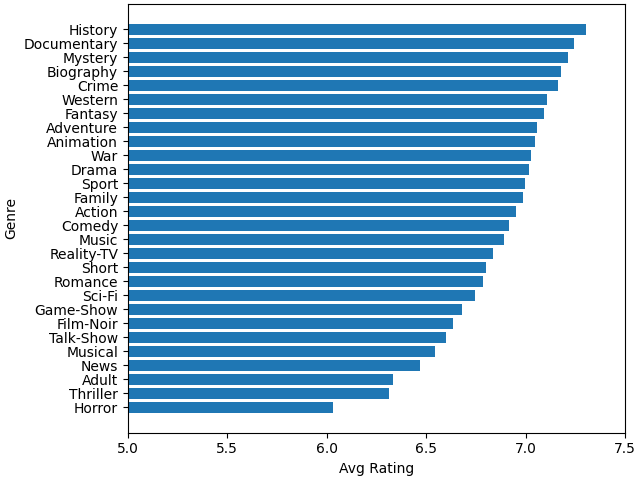

In [23]:
plt.clf()
plt.figure(constrained_layout=True)
plt.barh(avg_rating_genre_pd['genre'],avg_rating_genre_pd['avg_rating'])
plt.xlim(5,7.5)
plt.gca().invert_yaxis()
plt.xlabel("Avg Rating")
plt.ylabel("Genre")
plt.show()
%matplot plt

## PART 3 - Analyzing Job Categories

## Total Unique Job Categories

**What is the total number of unique job categories?**

In [24]:
movie_actors.select("category").distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

12

**What are the unique job categories available?**

In [25]:
movie_actors.select("category").distinct().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+
|           category|
+-------------------+
|            actress|
|           producer|
|production_designer|
|             writer|
|              actor|
|    cinematographer|
|      archive_sound|
|    archive_footage|
|               self|
|             editor|
|           composer|
|           director|
+-------------------+

## Top Job Categories

Now let's find the top job categories in this dataset by rolling up categories.

### Counts of Titles / Job Category

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [26]:
movie_actors.groupBy("category").agg(count("*").alias("count")).orderBy(col("count").desc()).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------+
|           category|  count|
+-------------------+-------+
|              actor|8493701|
|            actress|6325097|
|               self|6153089|
|             writer|4811596|
|           director|4179106|
|           producer|2197866|
|           composer|1313187|
|    cinematographer|1300404|
|             editor|1197669|
|production_designer| 285924|
|    archive_footage| 209035|
|      archive_sound|   2143|
+-------------------+-------+

### Bar Chart of Top Job Categories

With this data available, let us now build a barchart of the top 5 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [27]:
top_categories = movie_actors.groupBy("category").agg(count("*").alias("count")).orderBy(col("count").desc())
top_categories_pd = top_categories.toPandas()
top_categories_pd = top_categories_pd.head(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

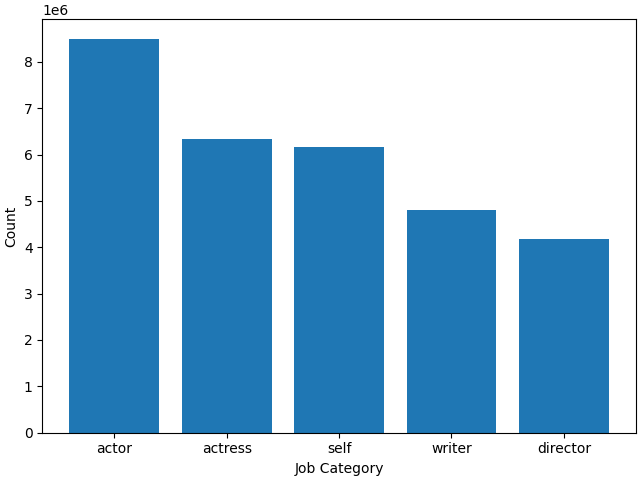

In [28]:
plt.clf()
plt.figure(constrained_layout=True)
plt.bar(top_categories_pd['category'],top_categories_pd['count'])
plt.xlabel("Job Category")
plt.ylabel("Count")
plt.show()
%matplot plt

# PART 4 - Answer to the following questions:

## 1) Find all the movies acted by both Johnny Depp and Helena Bonham Carter

First join actors, genres, and movie actors on each other

Note: Your code should meet all the requirements

In [29]:
movie_actors_actors = movie_actors.filter((movie_actors.category =="actor")|(movie_actors.category =="actress")).join(actors,movie_actors.nconst==actors.nconst,"inner")

movie_actors_genre = movie_actors_actors.join(genres,movie_actors_actors.tconst==genres.tconst,"inner")


JohnnyHelena = movie_actors_genre.filter(((col("primaryName")=="Johnny Depp")|(col("primaryName")=="Helena Bonham Carter"))&(col("titleType")=="movie"))
JohnnyHelena.groupBy("primaryTitle").agg(count("*").alias("Count")).filter(col("Count")>1).select("primaryTitle").show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------------------------+
|primaryTitle                                  |
+----------------------------------------------+
|Corpse Bride                                  |
|Dark Shadows                                  |
|Charlie and the Chocolate Factory             |
|Alice Through the Looking Glass               |
|Sweeney Todd: The Demon Barber of Fleet Street|
|Alice in Wonderland                           |
+----------------------------------------------+

## 2) Find all the movies acted by Brad Pitt after 2010.

Note: Your code should meet all the requirements

In [30]:
movie_actors_genre.filter((col("primaryName")=="Brad Pitt")&(col("titleType")=="movie")&(col("startYear")>2010)).orderBy(col("startYear").asc()).select("primaryTitle","startYear").show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------------------+---------+
|primaryTitle                     |startYear|
+---------------------------------+---------+
|The Tree of Life                 |2011     |
|Moneyball                        |2011     |
|Killing Them Softly              |2012     |
|12 Years a Slave                 |2013     |
|World War Z                      |2013     |
|Fury                             |2014     |
|The Big Short                    |2015     |
|By the Sea                       |2015     |
|Allied                           |2016     |
|War Machine                      |2017     |
|Ad Astra                         |2019     |
|Once Upon a Time ... in Hollywood|2019     |
|Babylon                          |2021     |
+---------------------------------+---------+

## 3) What is the number of movies acted by Zendaya per year?

Note: Your code should meet all the requirements

In [31]:
movie_actors_genre.filter((col("primaryName")=="Zendaya")&(col("titleType")=="movie")&(col("startyear")!= "\\N")).groupBy("startYear").count().show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-----+
|startYear|count|
+---------+-----+
|2020     |1    |
|2018     |2    |
|2017     |1    |
+---------+-----+

## 4) What are the movies by average rating greater than 9.7 and released in 2019?

Note: Your code should meet all the requirements

In [32]:
movie_ratings_genres = movie_ratings.join(genres,movie_ratings.tconst==genres.tconst,"inner")

movie_ratings_genres.filter((col("startYear")==2019)&(col("averageRating")>9.7)&(col("titleType")=="movie")).orderBy(col("averageRating").desc()).select("primaryTitle","averageRating").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------+
|        primaryTitle|averageRating|
+--------------------+-------------+
|Puritan: All of L...|          9.9|
|        The Cardinal|          9.9|
|         Superhombre|          9.9|
|Kamen Rider Zi-O:...|          9.8|
|     Time and motion|          9.8|
|We Shall Not Die Now|          9.8|
|          Square One|          9.8|
|            Randhawa|          9.8|
|   From Shock to Awe|          9.8|
|   Gini Helida Kathe|          9.8|
|              Kirket|         10.0|
|   Our Scripted Life|         10.0|
|The Twilight Zone...|         10.0|
|      A Grunt's Life|         10.0|
|Bu Can Var Oldugu...|         10.0|
|   L'Enfant Terrible|         10.0|
| The Butcher Baronet|         10.0|
|A Medicine for th...|         10.0|
|    Love in Kilnerry|         10.0|
+--------------------+-------------+

## Extra Credit - Analysis of your choice (1.5 pts)

Try and analyze some interesting dimension to this data. You should specify the name of the analysis in your Project2_Analysis.ipynb. This part similar to Part 2 and Part 3. Use different columns. 

•	You must create at least one visual.

3 actors with the most number of movies

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

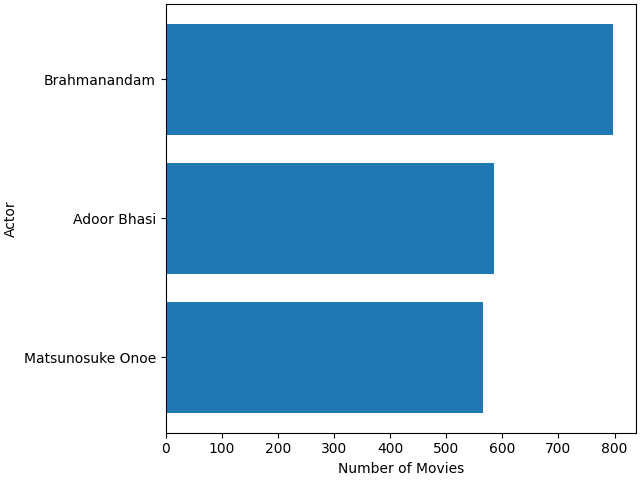

In [33]:
movie_actors_actors = movie_actors.filter((movie_actors.category =="actor")|(movie_actors.category =="actress")).join(actors,movie_actors.nconst==actors.nconst,"inner")

actor_movie_total = movie_actors_actors.join(genres,movie_actors_actors.tconst==genres.tconst,"inner").filter((col("titleType")=="movie")).groupBy("primaryName").agg(count("*").alias("movie_count")).orderBy(col("movie_count").desc()).toPandas()

top3 = actor_movie_total.head(3)
plt.clf()
plt.barh(top3['primaryName'],top3['movie_count'])
plt.gca().invert_yaxis()
plt.xlabel("Number of Movies")
plt.ylabel("Actor")
%matplot plt

# Extra Credit - Answering a question of your choice (1.5 pts)

Come up an answer to a question like in Part 4. The question of your choice should not be similar to the ones given in Part 4. Try to find an interesting question using different columns (i.e. num_votes, runtime). You should specify the question in Project2_Analysis.ipynb. 

•	You must join at least two datasets.